In [ ]:
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv("sample_submission.csv")

print(train.head())

         date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10


**<h3>Pre-Process Data for LSTM</h3>**

<h4>1. Handle Date column</h4>

In [ ]:
train['date'] = pd.to_datetime(train['date'])
train.set_index('date', inplace = True)
# Sort
train.sort_index(inplace = True)

<h4>2. Select and Scale features</h4>

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train[['sales']])

print("Scaled Data:\n", train_scaled[:5])

Scaled Data:
 [[0.05627706]
 [0.11255411]
 [0.11688312]
 [0.23376623]
 [0.15151515]]


<h4>3. Create Time-Series Sequences</h4>

In [ ]:
import numpy as np

sequence_length = 30 # say 30 days for a month

# prepare sequences
X, y = [], []
for i in range(sequence_length, len(train_scaled)):
  X.append(train_scaled[i - sequence_length:i, 0])
  y.append(train_scaled[i, 0])

# convert to numpy arrays
X, y = np.array(X), np.array(y)


# Reshape for LSTM input (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)
print("Shape of X: ", X.shape)
print("Shape of y", y.shape)



Shape of X:  (912970, 30, 1)
Shape of y (912970,)


**<h3>Define and Train the LSTM Model</h3>**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.mixed_precision import set_global_policy

# Enable mixed precision
set_global_policy('mixed_float16')

# Define LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Output layer
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

**<h3>Train the Model</h3>**

In [ ]:
# Split the training set in Training and Validation sets
split = int(0.8 * len(X))

X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

History = model.fit(X_train, y_train, epochs = 20, batch_size = 32, validation_data=(X_val, y_val))

Epoch 1/20
 1681/22825 ━━━━━━━━━━━━━━━━━━━━ 17:52 51ms/step - loss: 0.0134

In [ ]:
# Predict on validation set
y_pred = model.predict(X_val)

# Inverse transform to original scale
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_val_rescaled = scaler.inverse_transform(y_val.reshape(-1, 1))

# Visualize predictions vs actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_val_rescaled, label='Actual Sales')
plt.plot(y_pred_rescaled, label='Predicted Sales', linestyle='--')
plt.title("Actual vs Predicted Sales")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.legend()
plt.show()


In [ ]:
sample_submission['Sales'] = y_pred_rescaled.flatten()
sample_submission.to_csv('submission.csv', index=False)

# Download the file
from google.colab import files
files.download('submission.csv')


In [4]:
!pip3 install tfts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 2.0 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
# import tfts

In [4]:
# Load the data
df = pd.read_csv("train.csv")
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace = True)
df.sort_index(inplace = True)

In [5]:
# Scale the data
scaler = MinMaxScaler()
df['Sales'] = scaler.fit_transform(df[['sales']])

In [6]:
# Define function for creating sequence
def create_sequence(data, sequence_length, target_col):
  X, y = [], []
  for i in range(len(data) - sequence_length):
    X.append(data[i:i+sequence_length])
    y.append(data[i+sequence_length, target_col])
  return np.array(X), np.array(y)

# Hyperparameters
SEQUENCE_LENGTH = 30
TARGET_COL = 0    # assuming first column is the target(Sales)

#Create Sequences
data = df.values
X, y = create_sequence(data, SEQUENCE_LENGTH, TARGET_COL)

#Split training and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


**<h3>Define the Temporal Fusion Transformer Model</h3>**

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, MultiHeadAttention, Dropout, LayerNormalization, Concatenate
from tensorflow.keras.models import Model

# Define custom Temporal Fusion Transformer
def build_tft(input_shape):
    # Input layers
    inputs = Input(shape=input_shape)

    # LSTM encoder
    lstm_out = LSTM(64, return_sequences=True)(inputs)
    lstm_out = LSTM(64, return_sequences=True)(lstm_out)

    # Multi-head attention
    mha_out = MultiHeadAttention(num_heads=4, key_dim=64)(lstm_out, lstm_out)
    mha_out = Dropout(0.2)(mha_out)
    mha_out = LayerNormalization(epsilon=1e-6)(mha_out + lstm_out)  # Add & Norm

    # Fully connected layer
    dense_out = Dense(64, activation="relu")(mha_out)
    outputs = Dense(1)(dense_out)  # Output layer for predictions

    # Create model
    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])

    return model

# Build model
input_shape = (30, 1)  # Example: 30 time steps, 1 feature
tft_model = build_tft(input_shape)
tft_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 30, 1)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 30, 64)         │         16,896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 30, 64)         │         33,024 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 30, 64)         │         66,368 │ lstm_1[0][0],          │
│ (MultiHeadAttention)      │                        │                │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 30, 64)         │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 30, 64)         │              0 │ dropout_1[0][0],       │
│                           │                        │                │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 30, 64)         │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 30, 64)         │          4,160 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 30, 1)          │             65 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 120,641 (471.25 KB)

 Trainable params: 120,641 (471.25 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Check the shape of the data
print("X_train shape:", X_train.shape)  # Expected: (num_samples, seq_length, num_features)
print("y_train shape:", y_train.shape)  # Expected: (num_samples,)

# Reshape data if necessary
if len(X_train.shape) != 3:
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Verify shapes after reshaping
print("Reshaped X_train shape:", X_train.shape)
print("Reshaped X_test shape:", X_test.shape)


X_train shape: (730376, 30, 4)
y_train shape: (730376,)
Reshaped X_train shape: (730376, 30, 4)
Reshaped X_test shape: (182594, 30, 4)


In [9]:
# Ensure y_train and y_test are 2D
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print("Reshaped y_train shape:", y_train.shape)  # Expected: (num_samples, 1)
print("Reshaped y_test shape:", y_test.shape)


Reshaped y_train shape: (730376, 1)
Reshaped y_test shape: (182594, 1)


In [10]:
# Update input shape
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, features)

# Rebuild the model with the correct input shape
tft_model = build_tft(input_shape)
tft_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 30, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 30, 64)         │         17,664 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 30, 64)         │         33,024 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 30, 64)         │         66,368 │ lstm_3[0][0],          │
│ (MultiHeadAttention)      │                        │                │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 30, 64)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 30, 64)         │              0 │ dropout_3[0][0],       │
│                           │                        │                │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 30, 64)         │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 30, 64)         │          4,160 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 30, 1)          │             65 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 121,409 (474.25 KB)

 Trainable params: 121,409 (474.25 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the model
history = tft_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=128,
    verbose=1
)


Epoch 1/30
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 73s 11ms/step - loss: 8.3462 - mae: 2.5073 - val_loss: 8.3982 - val_mae: 2.5000
Epoch 2/30
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 77s 11ms/step - loss: 8.2495 - mae: 2.4976 - val_loss: 8.2616 - val_mae: 2.5000
Epoch 3/30
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 64s 11ms/step - loss: 8.2603 - mae: 2.5002 - val_loss: 8.2542 - val_mae: 2.5000
Epoch 4/30
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 8.2438 - mae: 2.4961 - val_loss: 8.2502 - val_mae: 2.5000
Epoch 5/30
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 64s 11ms/step - loss: 8.2595 - mae: 2.4999 - val_loss: 8.2792 - val_mae: 2.5000
Epoch 6/30
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 8.2628 - mae: 2.5007 - val_loss: 8.2586 - val_mae: 2.5000
Epoch 7/30
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 8.2654 - mae: 2.5014 - val_loss: 8.2504 - val_mae: 2.5000
Epoch 8/30
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 83s 11ms/step - loss: 8.2479 - mae: 2.4981 - val_loss: 8.2702 - val_mae: 2.5000
Epoch 9/30
5707/5707 ━━━

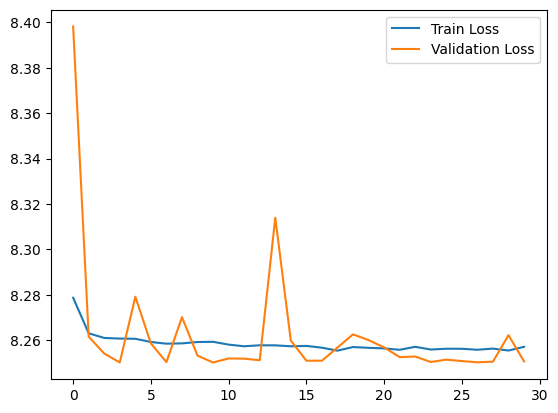

In [12]:
# Plot training history
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [14]:
# Make predictions
predictions = tft_model.predict(X_test)

# Reshape the predictions to 2D for inverse scaling
predictions_reshaped = predictions.reshape(-1, 1)

# Inverse scale predictions
predictions_rescaled = scaler.inverse_transform(predictions_reshaped)

# Inverse scale y_test
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))


5707/5707 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step


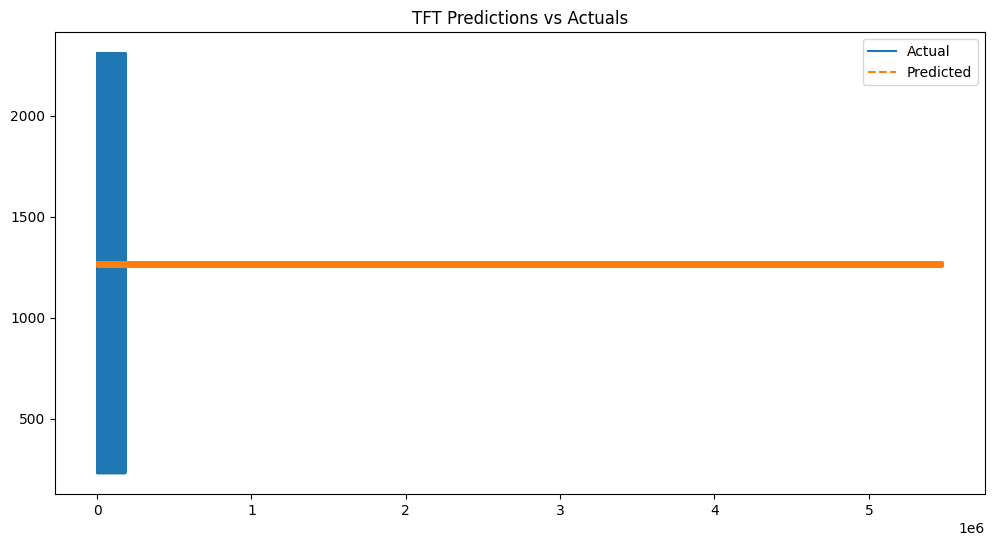

In [15]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual")
plt.plot(predictions_rescaled, label="Predicted", linestyle="--")
plt.legend()
plt.title("TFT Predictions vs Actuals")
plt.show()
